In [1]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked,words2answers
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2


# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Load and merge ground truth and MODEL data

In [3]:
!pwd

/home/davestanley/Dropbox/git/mindpocket/train_model/articles_batch2.0/model1e2c37


In [4]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [5]:
# Trim down newly loaded articles to match Narticles in training set
ind_train = slice(0,Ntrain)
ind_dev = slice(0,Ndev)

# Chosen display articles
ind_ex_train = 1                   # Example from training set - Chopin
ind_ex_dev = Ntrain + (467-442)    # Example from dev set - Immune system

In [6]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [7]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
if not sum(titles_match_bool) == len(titles_match_bool):
    raise ValueError('Articles mismatch.')


Matching titles: 55 
Total articles 55


In [8]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [9]:
arts[ind_ex_train]['paragraphs'][0]['context']

'Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: \u200b[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.'

In [10]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'


from utils_NLP import allenNLP_classify_blanks
arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [11]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
    if not sum(titles_match_bool) == len(titles_match_bool):
        raise ValueError('Articles mismatch.')

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [12]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [13]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

## AllenNLP Words

In [14]:
from utils_NLP import words2text
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

125
125
The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism 's own healthy tissue. In many species, the immune system can be classified into subsystems, such as the innate immune system versus the adaptive immune system, or humoral immunity versus cell - mediated immunity. In humans, the blood – brain barrier, blood – cerebrospinal fluid barrier, and similar fluid – brain barriers separate the peripheral immune system from the neuroimmune system which protects the brain.
708


## Context

In [15]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


125
The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism 's own healthy tissue. In many species, the immune system can be classified into subsystems, such as the innate immune system versus the adaptive immune system, or humoral immunity versus cell - mediated immunity. In humans, the blood – brain barrier, blood – cerebrospinal fluid barrier, and similar fluid – brain barriers separate the peripheral immune system from the neuroimmune system which protects the brain.
708


## Context_blanked

In [16]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

125
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
The immune ______ is a ______ of many biological structures and processes within an organism that protects against ______ . To function properly , an immune ______ must detect a wide variety of agents , known as ______ , from viruses to parasitic worms , and distinguish them from the organism 's own healthy tissue . In many species , the immune ______ can be classified into subsystems , such as the innate immune ______ versus the adaptive immune ______ , or humoral immunity versus cell - mediated immunity . In humans , the blood – brain barrier , blood – cerebrospinal fluid barrier , and similar fluid – brain ______ separate the peripheral immune ______ from the ______ ______ which protects the brain .


In [17]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

system
system
disease
system
pathogens
system
system
system
barriers
system
neuroimmune
system


# Single paragraph - Compare blanks

## First, just look at the raw text

In [18]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][1]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [19]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 124. Length ground truth blanks: 124


In [20]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
Disorders				______
of				of
the				the
immune				immune
system				______
can				can
result				result
in				in
autoimmune				______
diseases				______
,				,
inflammatory				______
diseases				______
and				and
cancer				______
.				.
______				______
______				occurs
when				when
the				the


## Ground truth blanked

In [21]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

Disorders of the immune system can result in autoimmune diseases, inflammatory diseases and cancer. ______ ______ when the immune system is less active than normal, resulting in recurring and life - threatening infections. In humans, ______ can either be the result of a genetic disease such as severe combined ______, acquired conditions such as HIV / AIDS, or the use of immunosuppressive medication. In contrast, ______ results from a hyperactive immune system attacking normal tissues as if they were foreign organisms. Common autoimmune diseases include Hashimoto 's thyroiditis, rheumatoid arthritis, diabetes mellitus type 1, and systemic lupus erythematosus. ______ covers the study of all aspects of the immune system.
Answers:
['Immunodeficiency', 'occurs', 'immunodeficiency', 'immunodeficiency', 'autoimmunity', 'Immunology']


In [22]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

______ of the immune ______ can result in ______ ______, ______ ______ and ______. ______ occurs when the immune ______ is less ______ than ______, resulting in recurring and ______ - threatening ______. In ______, ______ can either be the ______ of a genetic ______ such as severe combined ______, acquired ______ such as ______ / ______, or the ______ of immunosuppressive ______. In ______, ______ results from a hyperactive immune ______ attacking normal ______ as if they were ______ ______. Common autoimmune diseases include ______ 's ______, ______ ______, ______ ______ ______ ______, and systemic ______ ______. ______ covers the ______ of all ______ of the immune system.
Answers:
['Disorders', 'system', 'autoimmune', 'diseases', 'inflammatory', 'diseases', 'cancer', 'Immunodeficiency', 'system', 'active', 'normal', 'life', 'infections', 'humans', 'immunodeficiency', 'result', 'disease', 'immunodeficiency', 'conditions', 'HIV', 'AIDS', 'use', 'medication', 'contrast', 'autoimmunity',

In [23]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [24]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.6935483870967742
0.6935483870967742
5
37


In [25]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [26]:
print(TPR)
print(FPR)

0.8333333333333334
0.3135593220338983


In [27]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=6
Nsentences_from_words=6


In [28]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.8333333333333334
6.166666666666667


# Single article - compare blanks

In [29]:
##### Pull out sample paragraph
a = arts[ind_ex_dev]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Immune_system


In [30]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 7160. Length ground truth blanks: 7160


In [31]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
immune				immune
______				system
is				is
a				a
______				______
of				of
many				many
biological				biological
structures				______
and				and
processes				______
within				within
an				an
organism				______
that				that
protects				protects
against				against
______				______
.				.


In [32]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [33]:
print(ACC)
print(ACC2)

0.721927374301676
0.721927374301676


In [34]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [35]:
print(TPR)
print(FPR)

0.817966903073286
0.2841027163425857


In [36]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=287


In [37]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

1.2055749128919862
6.668989547038327


## Ground truth blanked

In [38]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'CRISPR', 'perforin', 'sequences', 'yellow', 'prostaglandins', 'Th1', 'variation', 'lysozyme', 'Burnet', 'sleep', 'NFIL3', 'immunomodulators', 'β-defensins', 'melatonin', 'protein', 'ligand', 'lupus', 'Immunodeficiencies', 'neuroimmune', 'Glucocorticoids', 'classes', 'methotrexate', 'Cytotoxic', 'autoimmune', 'Type', 'cytokine', 'adaptive', 'Trypanosoma', 'commensal', 'waxy', 'disorders', 'γδ', 'hagfish', 'exoskeleton', 'Macrophages', 'leptin', 'calcitriol', 'A', 'chemotaxis', 'Koch', 'histocompatibility', 'lactobacilli', 'passive', 'IgG', 'chronic', 'presentation', 'receptor', 'Antigen', 'CD40', 'D.', 'autoimmunity', 'infections', 'Immunology', 'Immunoproteomics', 'macrophages', 'granulysin', 'hormones', 'surveillance', 'Salmonella', 'molecules', 'cytokines', 'Breast', 'Leukocytes', 'gene', 'immunodeficiency', 'T', 'deprivation', 'relationship', 'CD4', 'CD8', 'specific', 'Da', 'cascade', '200–300', 'Dendritic', 'enzymes', 'fever', 'phagolysosome', 'MHC', 'milk', 'erythematos

In [39]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'substances', 'years', 'peak', 'turn', 'mutations', 'lifetime', 'patient', 'Pseudomonas', 'instances', 'variation', 'complexes', 'lysozyme', 'destruction', 'third', 'Hashimoto', 'ligand', 'Immunodeficiencies', 'generic', 'degranulation', 'group', 'lymphocyte', 'cytokine', 'deposition', 'bloodstream', 'strike', 'inducing', 'nose', 'lysis', 'heart', 'waxy', 'disorders', 'alarm', 'hagfish', 'Macrophages', 'characteristics', 'dermatitis', 'development', 'calcitriol', 'science', 'chemotaxis', 'immediate', 'products', 'version', 'lactobacilli', 'Antibodies', 'inducibility', 'mechanism', 'tolerance', 'Pierre', 'chronic', 'examples', 'immunogenic', '500', 'contact', 'layers', 'number', 'granulysin', 'way', 'molecules', 'cytokines', 'environments', 'TCR', 'copies', 'complicated', 'days', 'elements', 'dysfunctional', 'effect', 'loss', 'foreign', 'Da', '200–300', 'enzymes', 'killing', 'tyrosinase', 'situation', 'responses', 'death', 'other', 'vertebrates', 'phase', 'microbes', 'arm', 'p

# All articles - compare blanks

In [40]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))
    
    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))
        
        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100
        
        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)
        
        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2
    
    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    



In [41]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

In [42]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print(Ntrain)
print(Ndev)
print(Ntrain_bad)
print(Ndev_bad)



20
35
0
0


## Plot TPR

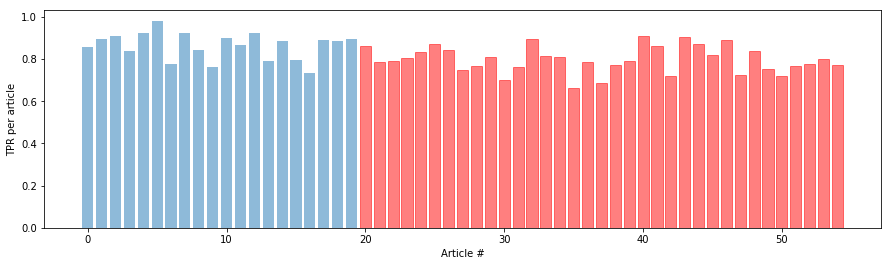

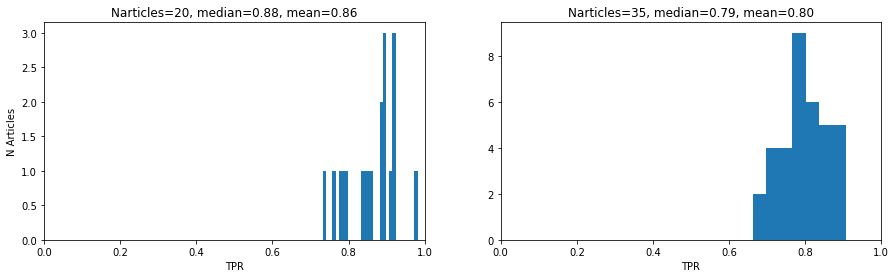

In [43]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot FPR

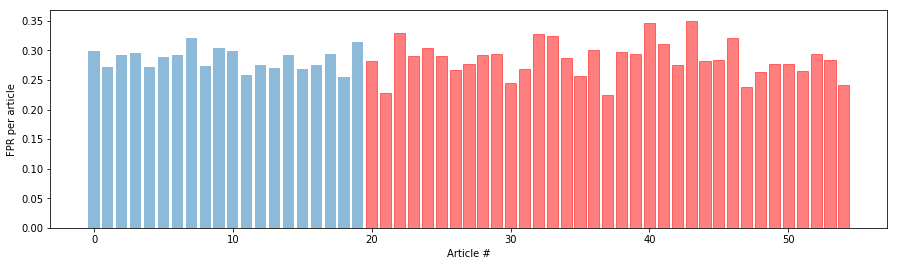

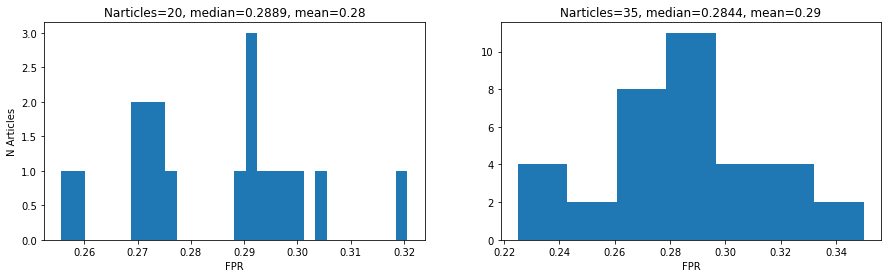

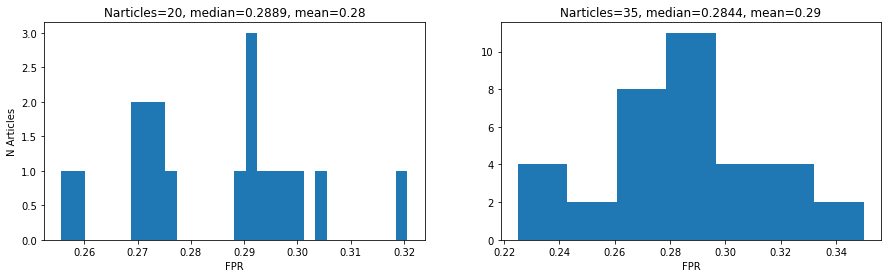

In [44]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

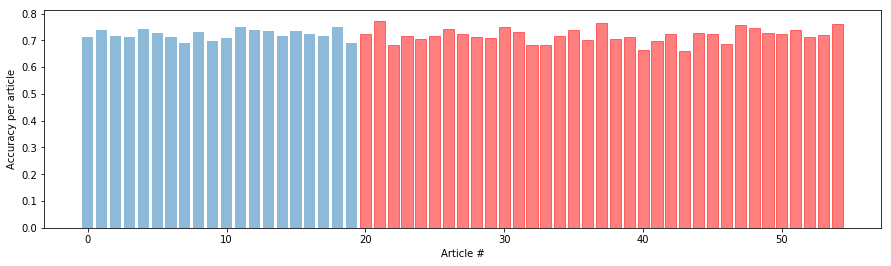

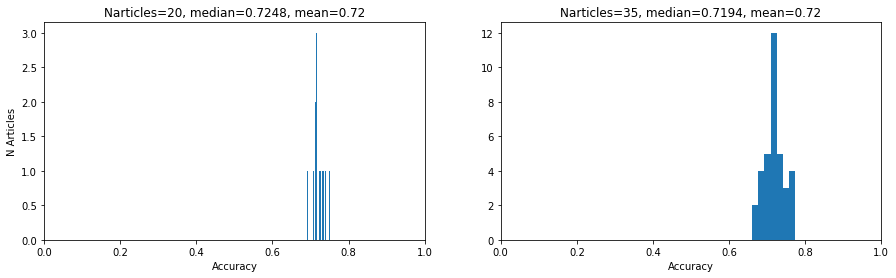

In [45]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

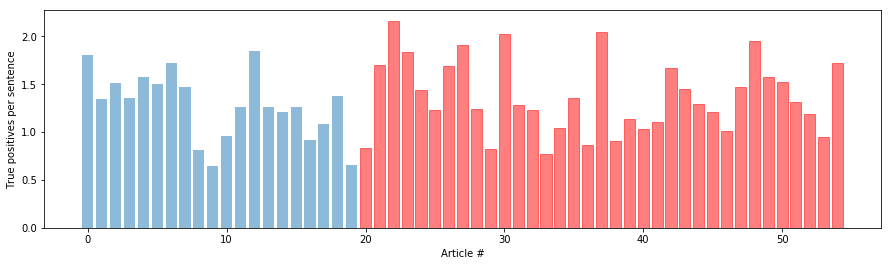

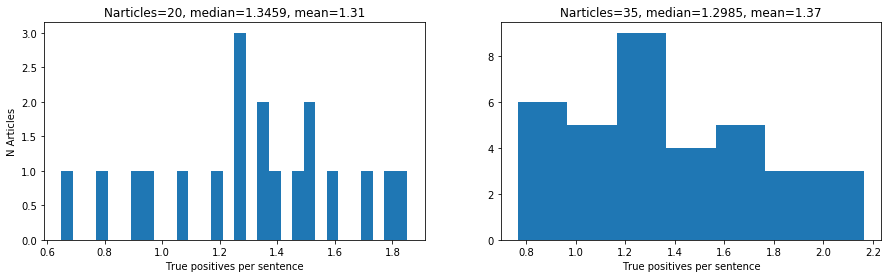

In [46]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

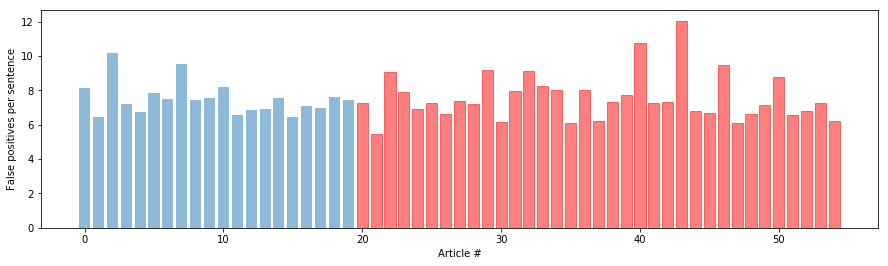

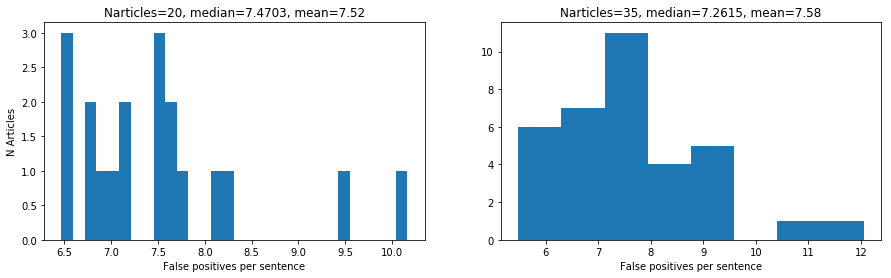

In [47]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [48]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

34
Article #54
Computational_complexity_theory
True positive rate: 0.7837209302325582


In [49]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Computational_complexity_theory


In [50]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				Computational
complexity				complexity
theory				theory
is				is
a				a
branch				______
of				of
the				the
theory				______
of				of
computation				______
in				in
theoretical				theoretical
computer				______
science				______
that				that
focuses				focuses
on				on
classifying				classifying
______				computational


## Ground truth blanked

In [51]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'intractable', 'written', 'problem', 'Problems', 'Myhill', 'decision', '21', 'deterministically', 'adjacency', 'suspected', 'taken', 'instances', 'lower', 'bounds', '1961', 'John', 'framework', '2000', 'solutions', 'computers', 'Interactive', 'reduces', 'classes', 'Ladner', 'Presburger', 'transitions', 'storage', 'inherent', 'Turing', 'isomorphism', 'Computational', 'triples', 'Cobham', 'NP', 'worst', 'language', 'reductions', 'symbols', 'models', 'proper', 'algorithms', 'size', 'PSPACE', 'graph', 'Yamada', 'quantum', 'number', 'matrices', 'Complexity', 'Decision', 'RSA', 'unusual', 'space', 'quantitative', 'bits', 'branching', 'complicated', 'integer', 'encoding', 'yes', 'factorization', 'analysis', 'notation', 'input', 'model', 'NL', 'theorem', '1', 'binary', 'arithmetic', 'second', 'measure', 'probabilistic', 'time', 'single', 'mathematical', 'bounding', 'reduction', 'solution', '1965', 'multiplication', 'possible', 'randomized', 'memory', 'efficient', 'formal', 'arbitrary

In [52]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'turn', 'answer', 'small', 'instances', 'John', 'solutions', 'computers', 'reduces', 'Ladner', 'pencil', 'Fortnow', 'practical', 'same', 'inherent', 'Raymond', 'Computational', 'triples', 'NP', 'language', '4', 'science', '1972', 'symbols', 'models', 'members', 'more', 'RAM', 'version', 'prime', 'inclusion', 'prediction', 'graph', 'Yamada', 'examples', 'cover', 'pairs', 'progress', 'number', 'latter', 'way', 'difference', 'branching', 'notation', '10', 'n.log', 'other', 'bit', 'program', 'times', 'task', 'AM', '1,000,000', '1960', 'kind', 'time', 'single', 'Clay', 'reduction', 'X.', 'Eugene', 'concept', 'researchers', 'Goldreich', 'principle', 'P', 'computations', 'thesis', 'order', 'phrase', 'objective', 'step', 'systems', 'unequal', 'Juris', 'question', 'Laszlo', 'Milan', 'half', 'FP', 'hierarchy', 'C.', 'others', 'smaller', 'branch', 'Algorithms', 'Y.', 'NC', 'DTIME(n2', 'salesman', 'DTIME(n', 'logarithmic', 'Alan', 'Edmonds', 'power', 'inclusions', 'algorithm', 'simplific

# All paragraphs - compare blanks

In [46]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [47]:
FPR0[0:10]

[0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064,
 0.00016278691193228064]

In [48]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [49]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


19035
1204
1383
13


## Plot TPR

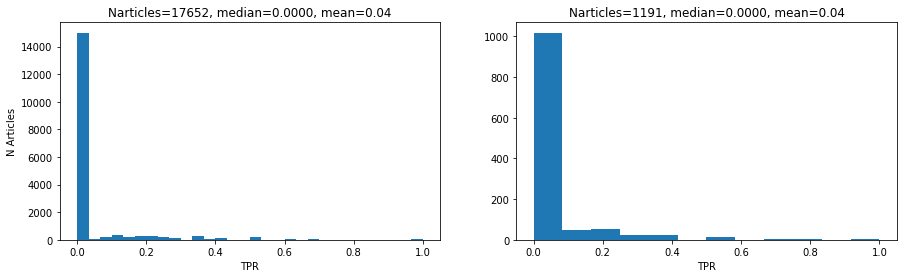

In [50]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [51]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

23
Article #442 paragraph #15
Normans
True positive rate: 0.5


In [252]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [253]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				______
______				______
,				,
an				an
other				other
Norman				Norman
adventurer				adventurer
previously				previously
elevated				elevated
to				to
the				the
dignity				dignity
of				of
count				count
of				of
Apulia				Apulia
as				as
the				the
result				result
of				of


## Ground truth blanked

In [249]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

______ ______ was descended from Huguenot refugees, as was ______ ______, who signed the Articles of Confederation for South Carolina; Jack Jouett, who made the ride from Cuckoo Tavern to warn Thomas Jefferson and others that Tarleton and his men were on their way to arrest him for crimes against the king; Francis Marion, and a number of other leaders of the American Revolution and later statesmen. The last active Huguenot congregation in North America worships in ______, South Carolina, at a church that dates to 1844. The Huguenot Society of America maintains Manakin Episcopal Church in Virginia as an historic shrine with occasional services. The Society has chapters in numerous states, with the one in ______ being the largest.
Answers:
['Paul', 'Revere', 'Henry', 'Laurens', 'Charleston', 'Texas']


In [250]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

______ ______ was descended from Huguenot refugees, as was ______ ______, who signed the Articles of Confederation for South Carolina; Jack Jouett, who made the ride from Cuckoo Tavern to warn Thomas Jefferson and others that Tarleton and his men were on their way to arrest him for crimes against the king; Francis Marion, and a number of other leaders of the American Revolution and later statesmen. The last active Huguenot congregation in North America worships in Charleston, South Carolina, at a church that dates to 1844. The Huguenot Society of America maintains Manakin Episcopal Church in Virginia as an historic shrine with occasional services. The Society has chapters in numerous states, with the one in Texas being the largest.
Answers:
['Paul', 'Revere', 'Henry', 'Laurens']


In [174]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [175]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.9255813953488372
0.9255813953488372
3
0


In [176]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [177]:
print(TPR)
print(FPR)

0.15789473684210525
0.0
